# Ungraded Lab: Using a Simple RNN for forecasting

In this lab, you will start to use recurrent neural networks (RNNs) to build a forecasting model. In particular, you will:

* build a stacked RNN using `simpleRNN` layers
* use `Lambda` layers to reshape the input and scale the output
* use the Huber loss during training
* use batched data windows to generate model predictions

You will train this on the same synthetic dataset from last week so the initial steps will be the same. Let's begin!

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-10-10 10:47:25.146184: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-10 10:47:25.168745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 10:47:25.189106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 10:47:25.192851: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 10:47:25.202467: I tensorflow/core/platform/cpu_feature_guar

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

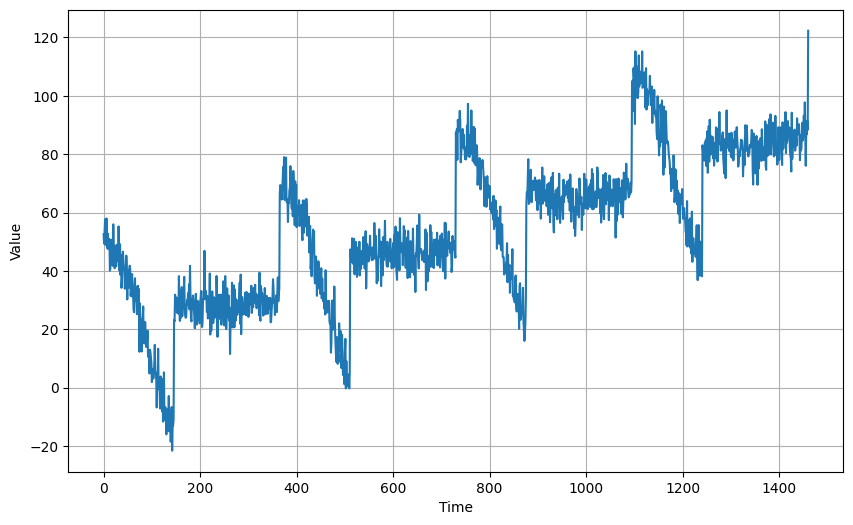

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

You will be using `SimpleRNN` layers later and as mentioned in its [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN#call_arguments), these expect a 3-dimensional tensor input with the shape `[batch, timesteps, feature`]. With that, you need to reshape your window from `(32, 20)` to `(32, 20, 1)`. This means the 20 data points in the window will be mapped to 20 timesteps of the RNN. To implement this, you will add an `expand_dims()` to the `windowed_dataset()` function you used in the previous labs. 

_Note: Technically, you will only need this extra line if you don't specify the input shape as you will do later when you build the model. Nonetheless, it is best practice to define transformations like this, especially in data pipelines. It can help make debugging easier in case you have problems later on._

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

I0000 00:00:1728568046.988109  155267 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568047.025888  155267 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568047.025933  155267 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568047.029183  155267 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728568047.029215  155267 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [8]:
# Print shapes of feature and label
for window in dataset.take(1):
  print(f'shape of feature: {window[0].shape}')
  print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20, 1)
shape of label: (32, 1)


2024-10-10 10:47:27.447441: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-10 10:47:27.448212: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Build the Model

Your model is composed mainly of [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) layers. As mentioned in the lectures, this type of RNN simply routes its output back to the input. You will stack two of these layers in your model so the first one should                    have `return_sequences` set to `True`. 

Normally, you can just have a `Dense` layer output as shown in the previous labs. However, you can help the training by scaling up the output to around the same figures as your labels. This will depend on the [activation functions](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) you used in your model. `SimpleRNN` uses *tanh* by default and that has an output range of `[-1,1]`. You will use a `Lambda` layer to scale the output by 100 before it adjusts the layer weights. `Lambda` layers can be a useful tool to experiment with simple transformations like this. Feel free to remove this layer later after this lab and see what results you get.

In [9]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size, 1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,961 (19.38 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

You will then tune the learning rate as before. You will define a learning rate schedule that changes this hyperparameter dynamically. You will use the [Huber Loss](https://en.wikipedia.org/wiki/Huber_loss) as your loss function to minimize sensitivity to outliers.

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100


I0000 00:00:1728568048.844063  155387 service.cc:146] XLA service 0x560ec1d98ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728568048.844097  155387 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-10-10 10:47:28.877802: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-10 10:47:28.959133: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


     20/Unknown 2s 9ms/step - loss: 49.7873

I0000 00:00:1728568049.358813  155387 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 49.0400 - learning_rate: 1.0000e-08
Epoch 2/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 40.3872 

2024-10-10 10:47:29.998196: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:47:29.998251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:29.998277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 39.1992 - learning_rate: 1.1220e-08
Epoch 3/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 29.1107

2024-10-10 10:47:30.319705: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:47:30.319762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:30.319787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 27.9960 - learning_rate: 1.2589e-08
Epoch 4/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.8957

2024-10-10 10:47:30.636245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:30.636298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.3639 - learning_rate: 1.4125e-08
Epoch 5/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.9488

2024-10-10 10:47:30.940855: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:47:30.940908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:30.940932: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.1437 - learning_rate: 1.5849e-08
Epoch 6/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.0990

2024-10-10 10:47:31.254519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:31.254581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.4158 - learning_rate: 1.7783e-08
Epoch 7/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.7683

2024-10-10 10:47:31.552122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:31.552188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13.1349 - learning_rate: 1.9953e-08
Epoch 8/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.4777

2024-10-10 10:47:31.868781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:31.868853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.8739 - learning_rate: 2.2387e-08
Epoch 9/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.2200

2024-10-10 10:47:32.197034: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:47:32.197089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:32.197113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 12.6196 - learning_rate: 2.5119e-08
Epoch 10/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.9727

2024-10-10 10:47:32.520889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:32.520956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.3763 - learning_rate: 2.8184e-08
Epoch 11/100
17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.7386

2024-10-10 10:47:32.858648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:32.858731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.1450 - learning_rate: 3.1623e-08
Epoch 12/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.6485

2024-10-10 10:47:33.203376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:33.203463: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.9234 - learning_rate: 3.5481e-08
Epoch 13/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.3816

2024-10-10 10:47:33.500647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:33.500716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.7125 - learning_rate: 3.9811e-08
Epoch 14/100
18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.1411

2024-10-10 10:47:33.822576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:33.822640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.5111 - learning_rate: 4.4668e-08
Epoch 15/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.8847

2024-10-10 10:47:34.140361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:34.140426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.3127 - learning_rate: 5.0119e-08
Epoch 16/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.6978

2024-10-10 10:47:34.505757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:34.505829: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.1126 - learning_rate: 5.6234e-08
Epoch 17/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.4534

2024-10-10 10:47:34.870061: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:47:34.870112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:34.870137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.9065 - learning_rate: 6.3096e-08
Epoch 18/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.3063

2024-10-10 10:47:35.261584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:35.261649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.6864 - learning_rate: 7.0795e-08
Epoch 19/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.0424

2024-10-10 10:47:35.645207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:35.645273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.4527 - learning_rate: 7.9433e-08
Epoch 20/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8494

2024-10-10 10:47:36.059732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:36.059806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.2115 - learning_rate: 8.9125e-08
Epoch 21/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.6033

2024-10-10 10:47:36.474215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:36.474276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.9621 - learning_rate: 1.0000e-07
Epoch 22/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.3808

2024-10-10 10:47:36.900758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:36.900824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.7156 - learning_rate: 1.1220e-07
Epoch 23/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1912

2024-10-10 10:47:37.310705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:37.310777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.4646 - learning_rate: 1.2589e-07
Epoch 24/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.9192

2024-10-10 10:47:37.705086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:37.705164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.1861 - learning_rate: 1.4125e-07
Epoch 25/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.5733

2024-10-10 10:47:38.083651: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:38.083718: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.8730 - learning_rate: 1.5849e-07
Epoch 26/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2500

2024-10-10 10:47:38.464127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:38.464214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.5515 - learning_rate: 1.7783e-07
Epoch 27/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9289

2024-10-10 10:47:38.867500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:38.867570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.2282 - learning_rate: 1.9953e-07
Epoch 28/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6142

2024-10-10 10:47:39.261248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:39.261338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.9405 - learning_rate: 2.2387e-07
Epoch 29/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3732

2024-10-10 10:47:39.673186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:39.673255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6842 - learning_rate: 2.5119e-07
Epoch 30/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0852

2024-10-10 10:47:40.075707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:40.075774: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4747 - learning_rate: 2.8184e-07
Epoch 31/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.8188

2024-10-10 10:47:40.525863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:40.525935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3191 - learning_rate: 3.1623e-07
Epoch 32/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8064

2024-10-10 10:47:40.955246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:40.955320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.1927 - learning_rate: 3.5481e-07
Epoch 33/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6632

2024-10-10 10:47:41.380378: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:47:41.380434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:41.380459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0992 - learning_rate: 3.9811e-07
Epoch 34/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.6008

2024-10-10 10:47:41.794802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:41.794866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0125 - learning_rate: 4.4668e-07
Epoch 35/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3676

2024-10-10 10:47:42.215598: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:42.215663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.9325 - learning_rate: 5.0119e-07
Epoch 36/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.2992

2024-10-10 10:47:42.725285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:42.725370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 6.8404 - learning_rate: 5.6234e-07
Epoch 37/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2184

2024-10-10 10:47:43.257151: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:43.257223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7327 - learning_rate: 6.3096e-07
Epoch 38/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1575

2024-10-10 10:47:43.700145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:43.700213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6487 - learning_rate: 7.0795e-07
Epoch 39/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9733

2024-10-10 10:47:44.126927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:44.126989: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.5632 - learning_rate: 7.9433e-07
Epoch 40/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9225

2024-10-10 10:47:44.565306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:44.565377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.4670 - learning_rate: 8.9125e-07
Epoch 41/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.8342

2024-10-10 10:47:44.981979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:44.982049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3934 - learning_rate: 1.0000e-06
Epoch 42/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7537

2024-10-10 10:47:45.417104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:45.417171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3304 - learning_rate: 1.1220e-06
Epoch 43/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6992

2024-10-10 10:47:45.842038: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:45.842111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2835 - learning_rate: 1.2589e-06
Epoch 44/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5526

2024-10-10 10:47:46.278181: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:46.278249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2276 - learning_rate: 1.4125e-06
Epoch 45/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6803

2024-10-10 10:47:46.694136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:46.694204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2262 - learning_rate: 1.5849e-06
Epoch 46/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7957

2024-10-10 10:47:47.118309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:47.118376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2333 - learning_rate: 1.7783e-06
Epoch 47/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9434

2024-10-10 10:47:47.533716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:47.533782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2780 - learning_rate: 1.9953e-06
Epoch 48/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.4518

2024-10-10 10:47:47.943972: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:47.944044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5191 - learning_rate: 2.2387e-06
Epoch 49/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6508

2024-10-10 10:47:48.334273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:48.334351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.6778 - learning_rate: 2.5119e-06
Epoch 50/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7083

2024-10-10 10:47:48.722675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:48.722738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7003 - learning_rate: 2.8184e-06
Epoch 51/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8095

2024-10-10 10:47:49.107861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:49.107936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8489 - learning_rate: 3.1623e-06
Epoch 52/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8120

2024-10-10 10:47:49.495024: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:49.495097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.7779 - learning_rate: 3.5481e-06
Epoch 53/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3790

2024-10-10 10:47:49.881910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:49.881986: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6950 - learning_rate: 3.9811e-06
Epoch 54/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5590

2024-10-10 10:47:50.237307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:50.237375: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.9290 - learning_rate: 4.4668e-06
Epoch 55/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5266

2024-10-10 10:47:50.620824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:50.620894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0060 - learning_rate: 5.0119e-06
Epoch 56/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.8148

2024-10-10 10:47:51.047646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:51.047715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0571 - learning_rate: 5.6234e-06
Epoch 57/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.5676

2024-10-10 10:47:51.457876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:51.457939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7403 - learning_rate: 6.3096e-06
Epoch 58/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3735

2024-10-10 10:47:51.870659: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:51.870734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.6091 - learning_rate: 7.0795e-06
Epoch 59/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6481

2024-10-10 10:47:52.309615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:52.309681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.8305 - learning_rate: 7.9433e-06
Epoch 60/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.6854

2024-10-10 10:47:52.717642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:52.717707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0578 - learning_rate: 8.9125e-06
Epoch 61/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1951

2024-10-10 10:47:53.152721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:53.152794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9000 - learning_rate: 1.0000e-05
Epoch 62/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.2899

2024-10-10 10:47:53.585219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:53.585299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9843 - learning_rate: 1.1220e-05
Epoch 63/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.0114

2024-10-10 10:47:53.989876: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:53.989939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.9597 - learning_rate: 1.2589e-05
Epoch 64/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.9651

2024-10-10 10:47:54.434279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:54.434350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1211 - learning_rate: 1.4125e-05
Epoch 65/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.8816

2024-10-10 10:47:54.855790: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:47:54.855839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:54.855864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.6231 - learning_rate: 1.5849e-05
Epoch 66/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3813

2024-10-10 10:47:55.258140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:55.258200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.4515 - learning_rate: 1.7783e-05
Epoch 67/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2021

2024-10-10 10:47:55.663135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:55.663204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.4681 - learning_rate: 1.9953e-05
Epoch 68/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.2860

2024-10-10 10:47:56.098296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:56.098363: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7206 - learning_rate: 2.2387e-05
Epoch 69/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.8031

2024-10-10 10:47:56.554474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:56.554532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3278 - learning_rate: 2.5119e-05
Epoch 70/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.7452

2024-10-10 10:47:56.982100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:56.982162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15.7702 - learning_rate: 2.8184e-05
Epoch 71/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 11.2944

2024-10-10 10:47:57.385968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:57.386057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.4105 - learning_rate: 3.1623e-05
Epoch 72/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.0850

2024-10-10 10:47:57.788223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:57.788288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.5458 - learning_rate: 3.5481e-05
Epoch 73/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7191

2024-10-10 10:47:58.203572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:58.203630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9368 - learning_rate: 3.9811e-05
Epoch 74/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9778 

2024-10-10 10:47:58.626308: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:58.626369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.1632 - learning_rate: 4.4668e-05
Epoch 75/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.2503

2024-10-10 10:47:59.035540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:59.035605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.1203 - learning_rate: 5.0119e-05
Epoch 76/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8026

2024-10-10 10:47:59.459846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:59.459909: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.7245 - learning_rate: 5.6234e-05
Epoch 77/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.6236

2024-10-10 10:47:59.880852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:47:59.880913: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.9768 - learning_rate: 6.3096e-05
Epoch 78/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.0245

2024-10-10 10:48:00.297467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:00.297532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.6301 - learning_rate: 7.0795e-05
Epoch 79/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.3189

2024-10-10 10:48:00.706700: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:00.706761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 14.5671 - learning_rate: 7.9433e-05
Epoch 80/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.1858

2024-10-10 10:48:01.109620: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:01.109682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.3508 - learning_rate: 8.9125e-05
Epoch 81/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 12.3450

2024-10-10 10:48:01.524818: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:01.524884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13.5887 - learning_rate: 1.0000e-04
Epoch 82/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 11.8977

2024-10-10 10:48:01.938366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:01.938437: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 14.9016 - learning_rate: 1.1220e-04
Epoch 83/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 17.0466

2024-10-10 10:48:02.359222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:02.359284: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15.8262 - learning_rate: 1.2589e-04
Epoch 84/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.4446

2024-10-10 10:48:02.763214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:02.763279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.0447 - learning_rate: 1.4125e-04
Epoch 85/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25.8555

2024-10-10 10:48:03.155459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:03.155520: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 22.5518 - learning_rate: 1.5849e-04
Epoch 86/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.6272

2024-10-10 10:48:03.565779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:03.565842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 23.0341 - learning_rate: 1.7783e-04
Epoch 87/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.0387

2024-10-10 10:48:03.958872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:03.958938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 18.2707 - learning_rate: 1.9953e-04
Epoch 88/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.3634

2024-10-10 10:48:04.357536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:04.357625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.5427 - learning_rate: 2.2387e-04
Epoch 89/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.7759

2024-10-10 10:48:04.752909: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:04.752974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 18.1954 - learning_rate: 2.5119e-04
Epoch 90/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.5932

2024-10-10 10:48:05.156709: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:05.156779: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 17.5704 - learning_rate: 2.8184e-04
Epoch 91/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 15.0899

2024-10-10 10:48:05.554599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:05.554669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 16.2109 - learning_rate: 3.1623e-04
Epoch 92/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.6520

2024-10-10 10:48:05.958142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:05.958214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.2308 - learning_rate: 3.5481e-04
Epoch 93/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.1715

2024-10-10 10:48:06.345773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:06.345842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.8825 - learning_rate: 3.9811e-04
Epoch 94/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 16.8250

2024-10-10 10:48:06.736674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:06.736740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.4258 - learning_rate: 4.4668e-04
Epoch 95/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.5176

2024-10-10 10:48:07.124854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:07.124919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 19.3509 - learning_rate: 5.0119e-04
Epoch 96/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 20.4956

2024-10-10 10:48:07.520934: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:07.521003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 20.4191 - learning_rate: 5.6234e-04
Epoch 97/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.5499

2024-10-10 10:48:07.920307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:07.920380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.7603 - learning_rate: 6.3096e-04
Epoch 98/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 25.8566

2024-10-10 10:48:08.310252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:08.310315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23.3596 - learning_rate: 7.0795e-04
Epoch 99/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.9885

2024-10-10 10:48:08.715750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:08.715815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 21.2274 - learning_rate: 7.9433e-04
Epoch 100/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 40.7732

2024-10-10 10:48:09.129918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:09.129987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 30.2054 - learning_rate: 8.9125e-04


2024-10-10 10:48:09.559460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:09.559519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


You can visualize the results and pick an optimal learning rate.

(1e-08, 0.001, 0.0, 50.0)

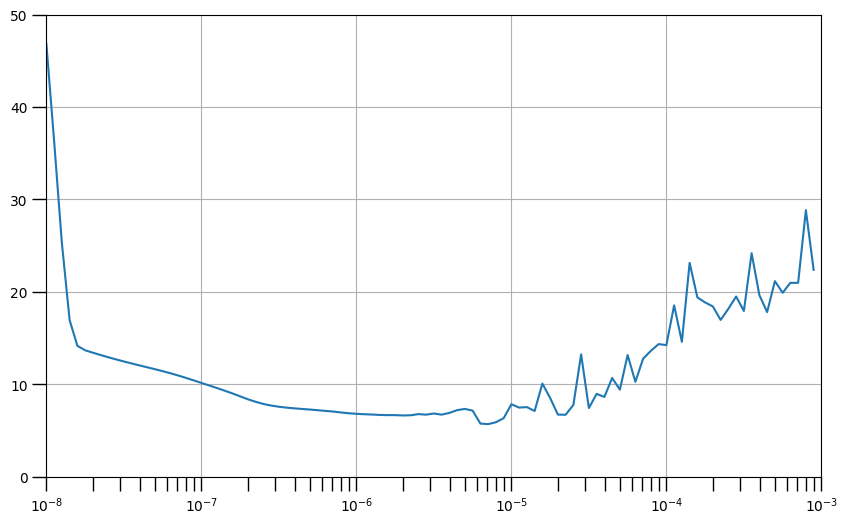

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

You can change the boundaries of the graph if you want to zoom in. The cell below chooses a narrower range so you can see more clearly where the graph becomes unstable.

(1e-07, 0.0001, 0.0, 20.0)

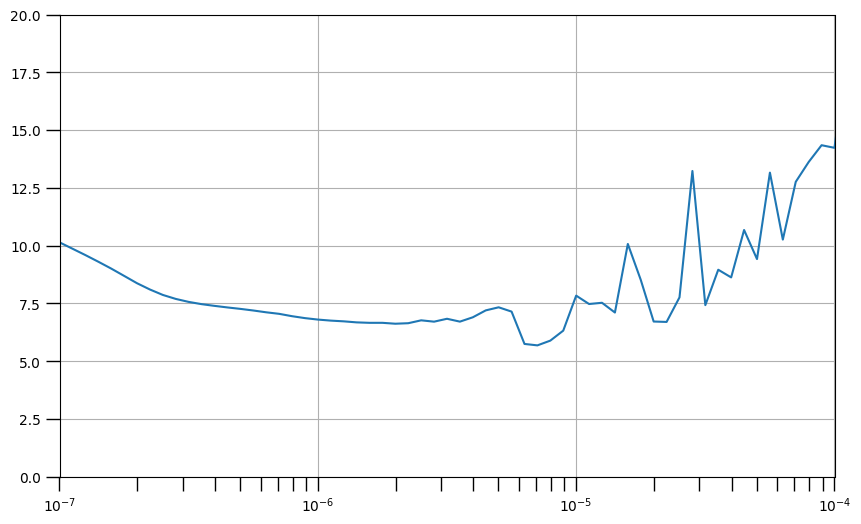

In [12]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

You can then declare the model again and train with the learning rate you picked. It is set to `1e-6`by default but feel free to change it.

In [13]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,1)),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 1e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 65.5830 - mae: 66.0820
Epoch 2/100
10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 17.5775 - mae: 18.0697

2024-10-10 10:48:12.414400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:12.414488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 15.9446 - mae: 16.4366
Epoch 3/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4403 - mae: 9.9287

2024-10-10 10:48:12.952151: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:12.952207: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 9.4933 - mae: 9.9785
Epoch 4/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.5262 - mae: 9.0001

2024-10-10 10:48:13.428330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:13.428396: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.6273 - mae: 9.1070
Epoch 5/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.2536 - mae: 8.7291

2024-10-10 10:48:13.882512: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:13.882576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.3255 - mae: 8.8054
Epoch 6/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.9656 - mae: 8.4345

2024-10-10 10:48:14.332419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:14.332485: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.0475 - mae: 8.5233
Epoch 7/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.8107 - mae: 8.2880

2024-10-10 10:48:14.790090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:14.790174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.8740 - mae: 8.3543
Epoch 8/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.7174 - mae: 8.1930

2024-10-10 10:48:15.266847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:15.266914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.7304 - mae: 8.2087
Epoch 9/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.5873 - mae: 8.0588

2024-10-10 10:48:15.734122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:15.734193: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.6028 - mae: 8.0801
Epoch 10/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.5207 - mae: 7.9920

2024-10-10 10:48:16.211232: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:16.211315: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.4902 - mae: 7.9672
Epoch 11/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.4369 - mae: 7.9094

2024-10-10 10:48:16.704320: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:16.704387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.3874 - mae: 7.8639
Epoch 12/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.3490 - mae: 7.8238

2024-10-10 10:48:17.147537: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:17.147611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2935 - mae: 7.7711
Epoch 13/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2704 - mae: 7.7486

2024-10-10 10:48:17.600893: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:17.600953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.2068 - mae: 7.6869
Epoch 14/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.1996 - mae: 7.6806

2024-10-10 10:48:18.044870: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:18.044933: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1313 - mae: 7.6131
Epoch 15/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.1291 - mae: 7.6104

2024-10-10 10:48:18.501970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:18.502040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 7.0607 - mae: 7.5431
Epoch 16/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.0698 - mae: 7.5505

2024-10-10 10:48:18.964817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:18.964891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.9910 - mae: 7.4730
Epoch 17/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.9839 - mae: 7.4613

2024-10-10 10:48:19.444950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:19.445023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.9261 - mae: 7.4068
Epoch 18/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.9357 - mae: 7.4117

2024-10-10 10:48:19.903545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:19.903612: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8606 - mae: 7.3395
Epoch 19/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8781 - mae: 7.3534

2024-10-10 10:48:20.367787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:20.367858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.7920 - mae: 7.2711
Epoch 20/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7994 - mae: 7.2756

2024-10-10 10:48:20.847344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:20.847419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7224 - mae: 7.2010
Epoch 21/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7305 - mae: 7.2069

2024-10-10 10:48:21.281908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:21.281976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.6545 - mae: 7.1331
Epoch 22/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6625 - mae: 7.1390

2024-10-10 10:48:21.741607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:21.741676: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5863 - mae: 7.0646
Epoch 23/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5827 - mae: 7.0580

2024-10-10 10:48:22.208225: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:22.208294: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5189 - mae: 6.9978
Epoch 24/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.5273 - mae: 7.0036

2024-10-10 10:48:22.684628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:22.684690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4543 - mae: 6.9332
Epoch 25/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4620 - mae: 6.9380

2024-10-10 10:48:23.140300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:23.140368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3924 - mae: 6.8712
Epoch 26/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.4034 - mae: 6.8786

2024-10-10 10:48:23.604830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:23.604899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.3396 - mae: 6.8179
Epoch 27/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3370 - mae: 6.8093

2024-10-10 10:48:24.092385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:24.092470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2916 - mae: 6.7687
Epoch 28/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.3017 - mae: 6.7751

2024-10-10 10:48:24.548497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:24.548573: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.2450 - mae: 6.7223
Epoch 29/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2531 - mae: 6.7274

2024-10-10 10:48:25.008125: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-10 10:48:25.008190: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:25.008216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1992 - mae: 6.6768
Epoch 30/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2045 - mae: 6.6790

2024-10-10 10:48:25.429821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:25.429910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1562 - mae: 6.6342
Epoch 31/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1590 - mae: 6.6337

2024-10-10 10:48:25.865288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:25.865355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1160 - mae: 6.5942
Epoch 32/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1179 - mae: 6.5922

2024-10-10 10:48:26.285892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:26.285959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0807 - mae: 6.5583
Epoch 33/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.0437 - mae: 6.5154

2024-10-10 10:48:26.737911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:26.737993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.0482 - mae: 6.5253
Epoch 34/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0448 - mae: 6.5175

2024-10-10 10:48:27.191974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:27.192044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0164 - mae: 6.4932
Epoch 35/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.0103 - mae: 6.4829

2024-10-10 10:48:27.629005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:27.629078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9857 - mae: 6.4620
Epoch 36/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9754 - mae: 6.4479

2024-10-10 10:48:28.066667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:28.066724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9557 - mae: 6.4320
Epoch 37/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.9334 - mae: 6.4042

2024-10-10 10:48:28.498528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:28.498581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.9245 - mae: 6.4006
Epoch 38/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.9029 - mae: 6.3731

2024-10-10 10:48:28.970374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:28.970431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.8958 - mae: 6.3709
Epoch 39/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8709 - mae: 6.3409

2024-10-10 10:48:29.389410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:29.389476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8691 - mae: 6.3441
Epoch 40/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8416 - mae: 6.3121

2024-10-10 10:48:29.849705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:29.849784: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8443 - mae: 6.3196
Epoch 41/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.8146 - mae: 6.2852

2024-10-10 10:48:30.291856: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:30.291914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.8209 - mae: 6.2963
Epoch 42/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7884 - mae: 6.2602

2024-10-10 10:48:30.744817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:30.744883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7980 - mae: 6.2741
Epoch 43/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7672 - mae: 6.2403

2024-10-10 10:48:31.164272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:31.164336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7753 - mae: 6.2521
Epoch 44/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7368 - mae: 6.2104

2024-10-10 10:48:31.590719: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:31.590794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7529 - mae: 6.2301
Epoch 45/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7110 - mae: 6.1851

2024-10-10 10:48:32.053230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:32.053319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7309 - mae: 6.2083
Epoch 46/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6774 - mae: 6.1515

2024-10-10 10:48:32.533690: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:32.533773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.7096 - mae: 6.1871
Epoch 47/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6536 - mae: 6.1278

2024-10-10 10:48:32.970707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:32.970785: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6887 - mae: 6.1660
Epoch 48/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6292 - mae: 6.1035

2024-10-10 10:48:33.429946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:33.430010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6673 - mae: 6.1445
Epoch 49/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6024 - mae: 6.0765

2024-10-10 10:48:33.907842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:33.907905: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.6461 - mae: 6.1233
Epoch 50/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5803 - mae: 6.0549

2024-10-10 10:48:34.428894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:34.428958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.6250 - mae: 6.1023
Epoch 51/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.4354 - mae: 5.9092

2024-10-10 10:48:34.918494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:34.918585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 5.6040 - mae: 6.0815
Epoch 52/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5319 - mae: 6.0070

2024-10-10 10:48:35.422706: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:35.422770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5829 - mae: 6.0606
Epoch 53/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5069 - mae: 5.9822

2024-10-10 10:48:35.917467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:35.917564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5614 - mae: 6.0392
Epoch 54/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4187 - mae: 5.8934

2024-10-10 10:48:36.399307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:36.399359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.5401 - mae: 6.0180
Epoch 55/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4680 - mae: 5.9436

2024-10-10 10:48:36.877868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:36.877927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.5189 - mae: 5.9970
Epoch 56/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4440 - mae: 5.9198

2024-10-10 10:48:37.362830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:37.362899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4981 - mae: 5.9762
Epoch 57/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4196 - mae: 5.8954

2024-10-10 10:48:37.807988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:37.808058: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4770 - mae: 5.9551
Epoch 58/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3848 - mae: 5.8603

2024-10-10 10:48:38.252401: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:38.252476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4561 - mae: 5.9341
Epoch 59/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.3711 - mae: 5.8467

2024-10-10 10:48:38.697832: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:38.697901: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.4352 - mae: 5.9132
Epoch 60/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3467 - mae: 5.8223

2024-10-10 10:48:39.136726: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:39.136806: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4142 - mae: 5.8922
Epoch 61/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2438 - mae: 5.7180

2024-10-10 10:48:39.602156: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:39.602216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3934 - mae: 5.8714
Epoch 62/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2985 - mae: 5.7738

2024-10-10 10:48:40.057150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:40.057219: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3727 - mae: 5.8506
Epoch 63/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2636 - mae: 5.7383

2024-10-10 10:48:40.520228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:40.520290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.3525 - mae: 5.8298
Epoch 64/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2527 - mae: 5.7277

2024-10-10 10:48:41.001095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:41.001150: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 5.3339 - mae: 5.8114
Epoch 65/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2317 - mae: 5.7068

2024-10-10 10:48:41.514897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:41.514951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3164 - mae: 5.7940
Epoch 66/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2115 - mae: 5.6869

2024-10-10 10:48:41.966172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:41.966236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2994 - mae: 5.7772
Epoch 67/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1071 - mae: 5.5813

2024-10-10 10:48:42.444609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:42.444702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2832 - mae: 5.7609
Epoch 68/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1612 - mae: 5.6365

2024-10-10 10:48:42.925496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:42.925579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2678 - mae: 5.7454
Epoch 69/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.0689 - mae: 5.5432

2024-10-10 10:48:43.400379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:43.400454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.2529 - mae: 5.7306
Epoch 70/100
 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.0500 - mae: 5.5244

2024-10-10 10:48:43.898199: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:43.898263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2379 - mae: 5.7158
Epoch 71/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1194 - mae: 5.5949

2024-10-10 10:48:44.381930: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:44.381997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2231 - mae: 5.7007
Epoch 72/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1032 - mae: 5.5782

2024-10-10 10:48:44.829287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:44.829355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2097 - mae: 5.6870
Epoch 73/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0876 - mae: 5.5620

2024-10-10 10:48:45.285329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:45.285400: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1968 - mae: 5.6738
Epoch 74/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0736 - mae: 5.5482

2024-10-10 10:48:45.761164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:45.761221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1849 - mae: 5.6620
Epoch 75/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0813 - mae: 5.5566

2024-10-10 10:48:46.210505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:46.210575: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1735 - mae: 5.6509
Epoch 76/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0479 - mae: 5.5229

2024-10-10 10:48:46.613889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:46.613944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1624 - mae: 5.6399
Epoch 77/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0484 - mae: 5.5236

2024-10-10 10:48:47.029380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:47.029447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1511 - mae: 5.6287
Epoch 78/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0360 - mae: 5.5112

2024-10-10 10:48:47.423894: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:47.423958: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.1399 - mae: 5.6175
Epoch 79/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0096 - mae: 5.4843

2024-10-10 10:48:47.857418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:47.857481: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1282 - mae: 5.6057
Epoch 80/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0096 - mae: 5.4844

2024-10-10 10:48:48.272585: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:48.272649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.1168 - mae: 5.5941
Epoch 81/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0052 - mae: 5.4801

2024-10-10 10:48:48.683357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:48.683429: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.1056 - mae: 5.5827
Epoch 82/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9835 - mae: 5.4581

2024-10-10 10:48:49.076407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:49.076478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0944 - mae: 5.5713
Epoch 83/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9568 - mae: 5.4309

2024-10-10 10:48:49.473866: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:49.473937: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0832 - mae: 5.5598
Epoch 84/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9215 - mae: 5.3943

2024-10-10 10:48:49.872433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:49.872514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0724 - mae: 5.5489
Epoch 85/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9468 - mae: 5.4205

2024-10-10 10:48:50.258562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:50.258624: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0619 - mae: 5.5381
Epoch 86/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9362 - mae: 5.4093

2024-10-10 10:48:50.657596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:50.657657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.0521 - mae: 5.5281
Epoch 87/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9350 - mae: 5.4081

2024-10-10 10:48:51.085791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:51.085863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0427 - mae: 5.5184
Epoch 88/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9164 - mae: 5.3889

2024-10-10 10:48:51.469373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:51.469440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0337 - mae: 5.5093
Epoch 89/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9158 - mae: 5.3884

2024-10-10 10:48:51.862884: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:51.862952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0248 - mae: 5.5002
Epoch 90/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9120 - mae: 5.3847

2024-10-10 10:48:52.250136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:52.250214: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0160 - mae: 5.4912
Epoch 91/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8875 - mae: 5.3592

2024-10-10 10:48:52.631697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:52.631759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.0072 - mae: 5.4823
Epoch 92/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8928 - mae: 5.3651

2024-10-10 10:48:53.033837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:53.033910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9985 - mae: 5.4734
Epoch 93/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8835 - mae: 5.3555

2024-10-10 10:48:53.412238: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:53.412302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9900 - mae: 5.4647
Epoch 94/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8683 - mae: 5.3397

2024-10-10 10:48:53.790535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:53.790597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.9816 - mae: 5.4561
Epoch 95/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8593 - mae: 5.3305

2024-10-10 10:48:54.186526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:54.186599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9734 - mae: 5.4477
Epoch 96/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8566 - mae: 5.3280

2024-10-10 10:48:54.569851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:54.569916: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9653 - mae: 5.4395
Epoch 97/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8420 - mae: 5.3130

2024-10-10 10:48:54.956409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:54.956474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9577 - mae: 5.4318
Epoch 98/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8245 - mae: 5.2951

2024-10-10 10:48:55.336602: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:55.336667: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9503 - mae: 5.4244
Epoch 99/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8258 - mae: 5.2968

2024-10-10 10:48:55.718952: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:55.719019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9429 - mae: 5.4171
Epoch 100/100
16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.8242 - mae: 5.2958

2024-10-10 10:48:56.100116: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:56.100192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.9358 - mae: 5.4099


2024-10-10 10:48:56.489680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14762237733773044987
2024-10-10 10:48:56.489745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13270333846573261918


## Model Prediction

Now it's time to generate the model predictions for the validation set time range. The model is a lot bigger than the ones you used before and the sequential nature of RNNs (i.e. inputs go through a series of time steps as opposed to parallel processing) can make predictions a bit slow. You can observe this when using the code you ran in the previous lab. This will take about a minute to complete.

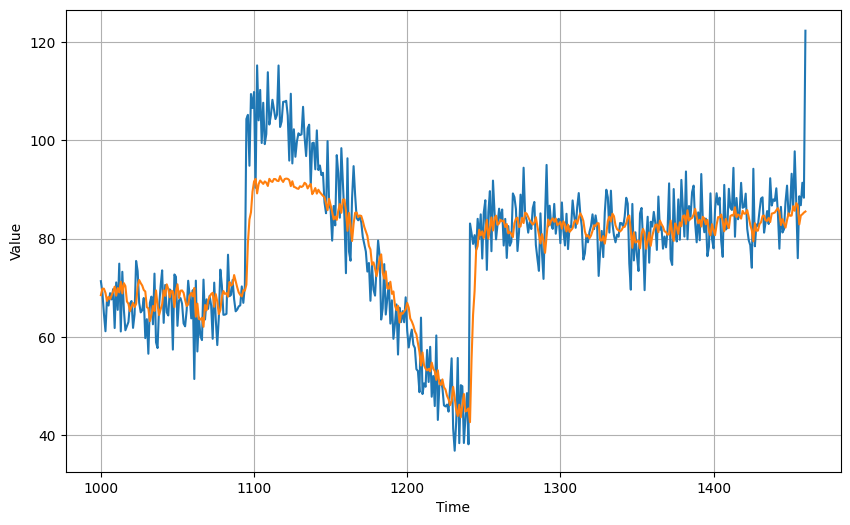

In [14]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can optimize this step by leveraging Tensorflow models' capability to process batches. Instead of running the for-loop above which processes a single window at a time, you can pass in an entire batch of windows and let the model process that in parallel.

The function below does just that. You will notice that it almost mirrors the `windowed_dataset()` function but it does not shuffle the windows. That's because we want the output to be in its proper sequence so we can compare it properly to the validation set.

In [15]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Add an axis for the feature dimension of RNN layers
    series = tf.expand_dims(series, axis=-1)
    
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset, verbose=0)
    
    return forecast

You can run the function below to use the function. Notice that the predictions are generated almost instantly.

*Note: You might notice that the first line slices the `series` at `split_time - window_size:-1` which is a bit different from the slower for-loop code. That is because we want the model to have its last prediction to align with the last point of the validation set (i.e. `t=1460`). You were able to do that with the slower for-loop code by specifying the for-loop's `range()`. With the more efficient function above, you don't have that mechanism so you instead just remove the last point when slicing the `series`. If you don't, then the function will generate a prediction at `t=1461` which is outside the validation set range.*

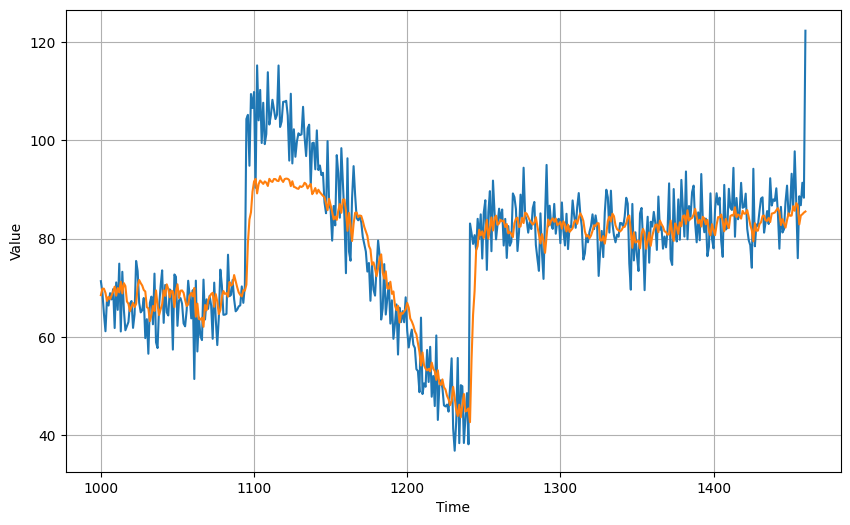

In [16]:
# Only needed in this lab. Reset the model but keep the trained weights to prepare for batched inputs.
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Reduce the original series
forecast_series = series[split_time - window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then compute the MSE and MAE. You can compare the results here when using other RNN architectures which you'll do in the next lab.

In [17]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

58.580128
5.618908


## Wrap Up

In the next lab, you will explore a similar architecture but using LSTMs. Before doing so, run the cell below to free up resources. You might see a pop-up about restarting the kernel afterwards. You can safely ignore it and just press Ok. You can then close this lab, then go back to the classroom for the next lecture. See you there!